In [1]:
import pandas as pd

# 讀取用戶上傳的 CSV 文件
file_path = '/Users/linwei-chi/Desktop/R final project/carbonpred_variables_version2.csv'
df = pd.read_csv(file_path)
# 顯示前幾列的資料以檢查其結構和內容
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Columns: 561 entries, Date to ftse_OBV_(3, 12)
dtypes: float64(560), object(1)
memory usage: 1.9+ MB


(         Date  carbon.Price  carbon.Open  carbon.High  carbon.Low  carbon.Vol  \
 0  2022-07-19         83.65        85.20        85.20       82.80       20.97   
 1  2022-07-20         78.84        83.60        83.64       78.70       38.18   
 2  2022-07-21         78.11        79.20        79.80       77.65       31.89   
 3  2022-07-22         76.30        78.20        79.80       76.00       28.56   
 4  2022-07-25         76.37        76.12        78.42       75.49       22.15   
 
      clean  oil.Price  oil.Open  oil.High  ...  ibex_OBV_(2, 9)  \
 0  1249.32     107.35    105.74    107.61  ...       -33447.222   
 1  1261.67     106.92    107.07    107.45  ...        52696.667   
 2  1253.44     103.86    106.49    106.78  ...       -63426.667   
 3  1253.04     103.20    103.86    105.72  ...       -35571.667   
 4  1261.86     105.15    103.85    105.38  ...       109311.111   
 
    ibex_OBV_(2, 12)  ibex_OBV_(3, 9)  ibex_OBV_(3, 12)  ftse_OBV_(1, 9)  \
 0       -178906.667

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np

# 將 Date 列設定為索引
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 計算與目標變數 'carbon.Price' 的相關係數
target = 'carbon.Price'
correlation = df.corr()[target].sort_values(ascending=False)

# 選出與目標變數相關性最強的前 15 個特徵（排除 'carbon.Price' 自身）
top_features = correlation.index[1:16]

# 篩選高相關特徵
selected_features = top_features.tolist()

# 提取目標變數和特徵
X = df[selected_features]
y = df[target]

# 分割訓練集（前 376 天）和測試集（最後 60 天）
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y[:-60], y[-60:]

In [3]:
print(y_test.index)  # 打印測試集的日期範圍

DatetimeIndex(['2024-01-04', '2024-01-05', '2024-01-08', '2024-01-09',
               '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-15',
               '2024-01-16', '2024-01-17', '2024-01-18', '2024-01-19',
               '2024-01-22', '2024-01-23', '2024-01-24', '2024-01-25',
               '2024-01-26', '2024-01-29', '2024-01-30', '2024-01-31',
               '2024-02-01', '2024-02-02', '2024-02-05', '2024-02-06',
               '2024-02-07', '2024-02-08', '2024-02-09', '2024-02-12',
               '2024-02-13', '2024-02-14', '2024-02-15', '2024-02-16',
               '2024-02-19', '2024-02-20', '2024-02-21', '2024-02-22',
               '2024-02-23', '2024-02-26', '2024-02-27', '2024-02-28',
               '2024-02-29', '2024-03-01', '2024-03-04', '2024-03-05',
               '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-11',
               '2024-03-12', '2024-03-13', '2024-03-14', '2024-03-15',
               '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21',
      

In [4]:
from sklearn.ensemble import RandomForestRegressor
# 結合多種方法的特徵選擇
def select_top_features(X_train, y_train, n_features=20):
    # 相關性分析
    corr_matrix = X_train.corr().abs()
    
    # 隨機森林特徵重要性
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train, y_train)
    rf_importance = rf_model.feature_importances_
    
    # 綜合排序
    feature_scores = pd.DataFrame({
        'feature': X_train.columns,
        'rf_importance': rf_importance
    }).sort_values('rf_importance', ascending=False)
    
    return feature_scores['feature'][:n_features].tolist()

# 選擇top特徵
top_features = select_top_features(X_train, y_train)
print("綜合篩選的top特徵：")
print(top_features)

# 使用篩選後的特徵進行建模
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

綜合篩選的top特徵：
['carbon.High', 'carbon.Low', 'carbon.Price_MA(1,12)', 'carbon.Open', 'carbon.Price_MOM(9)', 'carbon.Price_MOM(12)', 'clean', 'zvj24.Price', 'ruh24.Price', 'carbon.Price_MA(2,12)', 'rvh24.Price', 'carbon.Price_MA(3,12)', 'zuj24.Price', 'ygj24.Price', 'yih24.Price']


Training Progress:   0%|          | 0/286 [00:00<?, ?it/s]

Testing Progress: 100%|██████████| 60/60 [01:56<00:00,  1.94s/it]


Train RMSE: 1.24, Train R²: 0.96
Test RMSE: 1.45, Test R²: 0.91


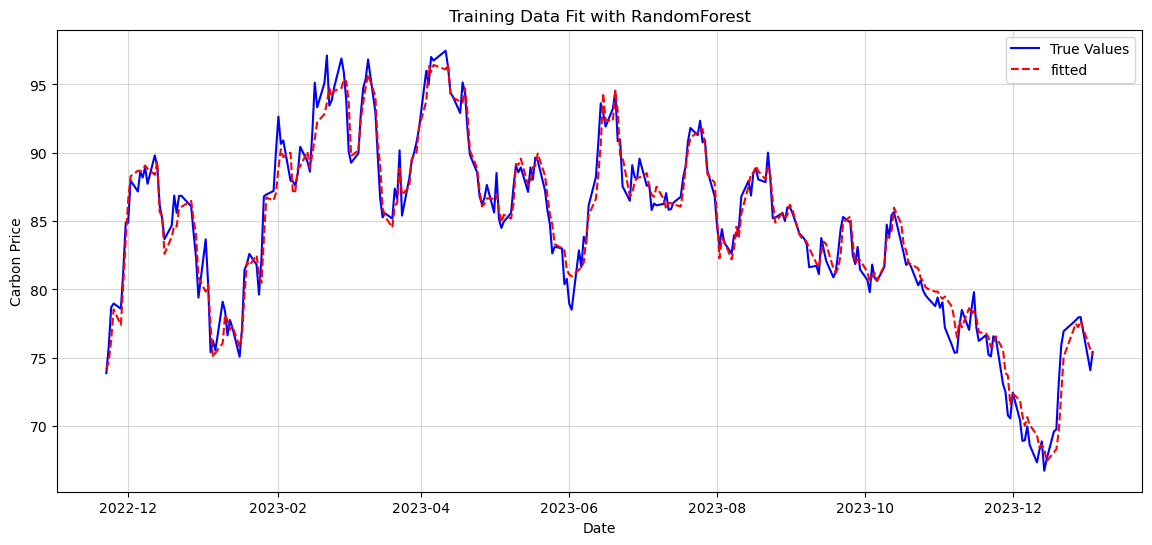

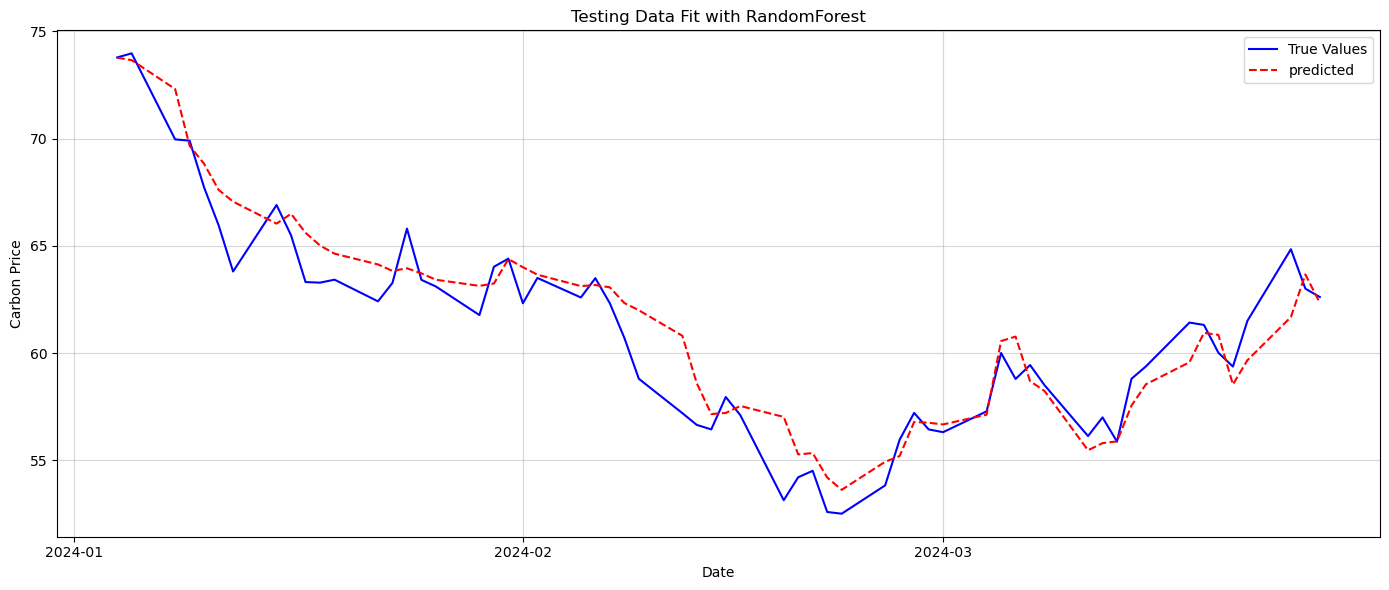

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from tqdm import tqdm  # 確保已安裝 tqdm


features = ['carbon.High', 'carbon.Low', 'carbon.Price_MA(1,12)', 'carbon.Open', 'carbon.Price_MOM(9)', 'carbon.Price_MOM(12)', 'zvj24.Price', 'clean', 'rvh24.Price', 'carbon.Price_MA(3,12)', 'ruh24.Price', 'carbon.Price_MA(2,12)', 'zuj24.Price', 'ygj24.Price', 'yih24.Price']

X = df[features].values
y = df[target].values

#parameter
# 參數設置
window_size = 90
test_size = 60
start_index = len(df) - test_size  # 測試集開始的位置
    
    # 定義參數網格（可以根據之前的Grid Search結果調整）
param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

#Training
train_predictions = []
train_true_values = []
train_dates = []
for i in tqdm(range(window_size, start_index),desc='Training Progress'):
    X_train_window = X[i-window_size:i]
    y_train_window = y[i-window_size:i]
    X_test_window = X[i:i+1]

    # 初始化模型
    rf = RandomForestRegressor(random_state=42)
        
    # 使用 GridSearchCV 進行參數調優
    grid_search = GridSearchCV(
            estimator=rf,
            param_grid=param_grid,
            scoring='neg_mean_squared_error',
            cv=5,
            n_jobs=-1
        )
        
    # 訓練模型
    grid_search.fit(X_train_window, y_train_window)
    # 使用最佳模型進行預測
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test_window)[0]
    # 預測
    train_predictions.append(y_pred)
    train_true_values.append(y[i])
    train_dates.append(df.index[i])

#Testing
test_predictions = []
test_true_values = []
test_dates = []

for i in tqdm(range(start_index, len(df)),desc='Testing Progress'):
    X_train_window = X[i-window_size:i]
    y_train_window = y[i-window_size:i]
    X_test_window = X[i:i+1]

    # 初始化模型
    rf = RandomForestRegressor(random_state=42)
        
    # 使用 GridSearchCV 進行參數調優
    grid_search = GridSearchCV(
            estimator=rf,
            param_grid=param_grid,
            scoring='neg_mean_squared_error',
            cv=5,
            n_jobs=-1
            )
    # 訓練模型
    grid_search.fit(X_train_window, y_train_window)

    # 使用最佳參數建立模型
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test_window)[0]

    test_predictions.append(y_pred)
    test_true_values.append(y[i])
    test_dates.append(df.index[i])

# 訓練集評估
train_rmse = np.sqrt(mean_squared_error(train_true_values, train_predictions))
train_r2 = r2_score(train_true_values, train_predictions)

# 測試集評估
test_rmse = np.sqrt(mean_squared_error(test_true_values, test_predictions))
test_r2 = r2_score(test_true_values, test_predictions)

print(f"Train RMSE: {train_rmse:.2f}, Train R²: {train_r2:.2f}")
print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

# 生成訓練集圖表
plt.figure(figsize=(14, 6))
plt.plot(train_dates, train_true_values, label='True Values', color='blue')
plt.plot(train_dates, train_predictions, label='fitted', color='red', linestyle='--')
plt.title('Training Data Fit with RandomForest')
plt.xlabel('Date')
plt.ylabel('Carbon Price')
plt.legend()
plt.grid(alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))


# 生成測試集圖表
plt.figure(figsize=(14, 6))
plt.plot(test_dates, test_true_values, label='True Values', color='blue')
plt.plot(test_dates, test_predictions, label='predicted', color='red', linestyle='--')
plt.title('Testing Data Fit with RandomForest')
plt.xlabel('Date')
plt.ylabel('Carbon Price')
plt.legend()
plt.grid(alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))



plt.tight_layout()
plt.show()


In [13]:
# 將測試集預測值存成 NumPy array
test_predictions_array = np.array(test_predictions)

# 將測試集預測值與對應日期存成 DataFrame（可選）
test_results_df = pd.DataFrame({
    'Date': test_dates,
    'True Value': test_true_values,
    'Predicted Value': test_predictions
})

# 可選：將結果輸出成 CSV 檔案
test_results_df.to_csv("test_predictions_rf_20241211_03_featurewithoutlags.csv", index=False)

Testing Progress: 100%|██████████| 60/60 [03:06<00:00,  3.11s/it]


Train RMSE: 1.23, Train R²: 0.96
Test RMSE: 1.46, Test R²: 0.91


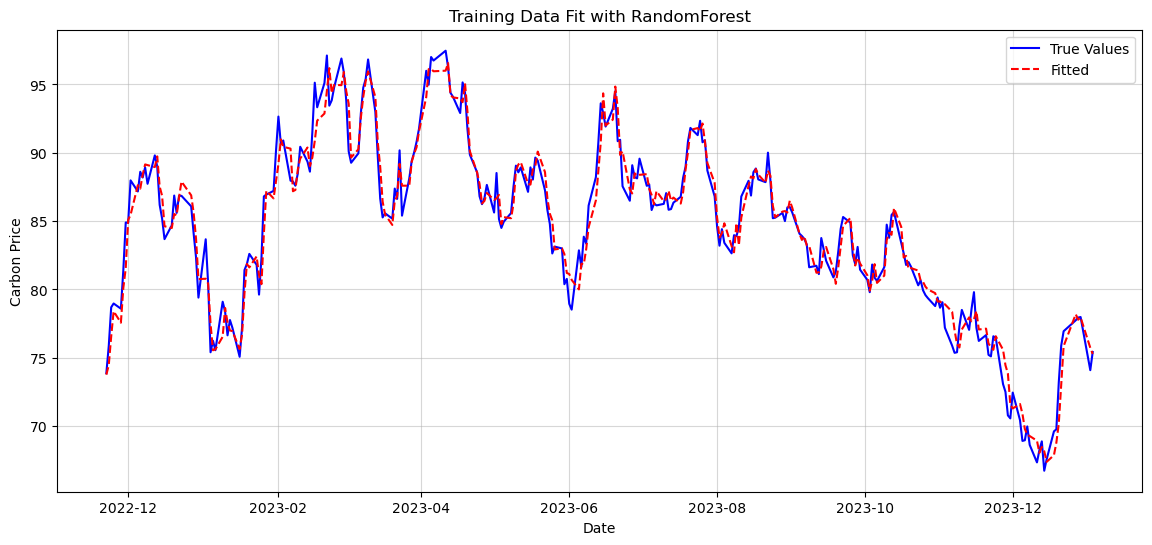

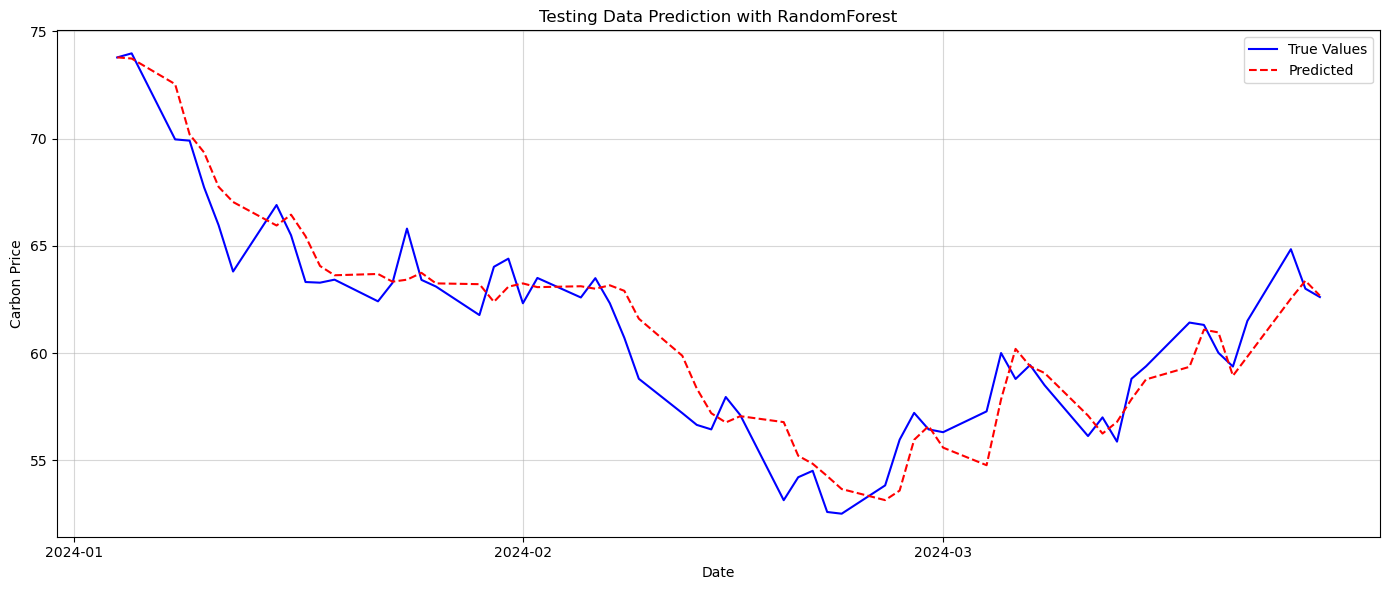

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from tqdm import tqdm

features = ['carbon.High', 'carbon.Low', 'carbon.Open', 'carbon.Open_lag3', 'carbon.Price_lag1', 'carbon.Low_lag1', 'carbon.Low_lag3', 'carbon.High_lag1', 'carbon.High_lag2', 'carbon.High_lag3']
target = 'carbon.Price'

X = df[features].values
y = df[target].values

# 參數設置
window_size = 90
test_size = 60
start_index = len(df) - test_size  # 測試集開始的位置
    
# 定義參數網格
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# 創建特徵矩陣的副本，用於更新預測值
temp_X = X.copy()

# 訓練集預測
train_predictions = []
train_true_values = []
train_dates = []

# 訓練階段
for i in tqdm(range(window_size, start_index), desc='Training Progress'):
    X_train_window = temp_X[i-window_size:i]
    y_train_window = y[i-window_size:i]
    X_test_window = temp_X[i:i+1]

    # 初始化模型
    rf = RandomForestRegressor(random_state=42)
        
    # 使用 GridSearchCV 進行參數調優
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )
        
    # 訓練模型
    grid_search.fit(X_train_window, y_train_window)
    
    # 使用最佳模型進行預測
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test_window)[0]
    
    # 預測
    train_predictions.append(y_pred)
    train_true_values.append(y[i])
    train_dates.append(df.index[i])
    
    # 更新特徵矩陣中的預測值
    temp_X[i, features.index('carbon.Price_lag1')] = y_pred

# 重置 temp_X 以便測試階段使用
temp_X = X.copy()

# 測試集預測
test_predictions = []
test_true_values = []
test_dates = []

# 測試階段
for i in tqdm(range(start_index, len(df)), desc='Testing Progress'):
    X_train_window = temp_X[i-window_size:i]
    y_train_window = y[i-window_size:i]
    X_test_window = temp_X[i:i+1]

    # 初始化模型
    rf = RandomForestRegressor(random_state=42)
        
    # 使用 GridSearchCV 進行參數調優
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )
    
    # 訓練模型
    grid_search.fit(X_train_window, y_train_window)

    # 使用最佳模型預測
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test_window)[0]

    # 記錄預測結果
    test_predictions.append(y_pred)
    test_true_values.append(y[i])
    test_dates.append(df.index[i])

    # 更新特徵矩陣中的預測值
    temp_X[i, features.index('carbon.Price_lag1')] = y_pred

# 訓練集評估
train_rmse = np.sqrt(mean_squared_error(train_true_values, train_predictions))
train_r2 = r2_score(train_true_values, train_predictions)

# 測試集評估
test_rmse = np.sqrt(mean_squared_error(test_true_values, test_predictions))
test_r2 = r2_score(test_true_values, test_predictions)

print(f"Train RMSE: {train_rmse:.2f}, Train R²: {train_r2:.2f}")
print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

# 生成訓練集圖表
plt.figure(figsize=(14, 6))
plt.plot(train_dates, train_true_values, label='True Values', color='blue')
plt.plot(train_dates, train_predictions, label='Fitted', color='red', linestyle='--')
plt.title('Training Data Fit with RandomForest')
plt.xlabel('Date')
plt.ylabel('Carbon Price')
plt.legend()
plt.grid(alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

# 生成測試集圖表
plt.figure(figsize=(14, 6))
plt.plot(test_dates, test_true_values, label='True Values', color='blue')
plt.plot(test_dates, test_predictions, label='Predicted', color='red', linestyle='--')
plt.title('Testing Data Prediction with RandomForest')
plt.xlabel('Date')
plt.ylabel('Carbon Price')
plt.legend()
plt.grid(alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.tight_layout()
plt.show()

In [8]:
# 將測試集預測值存成 NumPy array
test_predictions_array = np.array(test_predictions)

# 將測試集預測值與對應日期存成 DataFrame（可選）
test_results_df = pd.DataFrame({
    'Date': test_dates,
    'True Value': test_true_values,
    'Predicted Value': test_predictions
})

# 可選：將結果輸出成 CSV 檔案
test_results_df.to_csv("test_predictions_rf_20241211_02.csv", index=False)

Print param (最終版！)

Testing Progress: 100%|██████████| 60/60 [03:11<00:00,  3.20s/it]


Train RMSE: 1.22, Train R²: 0.97
Test RMSE: 1.46, Test R²: 0.91

Training Best Parameters Summary:
n_estimators: {'most_frequent': 200, 'value_counts': {200: 145, 100: 141}}
max_depth: {'most_frequent': None, 'value_counts': {None: 187, 10: 99}}
min_samples_split: {'most_frequent': 2, 'value_counts': {2: 229, 5: 57}}
min_samples_leaf: {'most_frequent': 1, 'value_counts': {1: 215, 2: 71}}

Testing Best Parameters Summary:
n_estimators: {'most_frequent': 100, 'value_counts': {200: 22, 100: 38}}
max_depth: {'most_frequent': None, 'value_counts': {None: 47, 10: 13}}
min_samples_split: {'most_frequent': 2, 'value_counts': {2: 35, 5: 25}}
min_samples_leaf: {'most_frequent': 1, 'value_counts': {1: 46, 2: 14}}


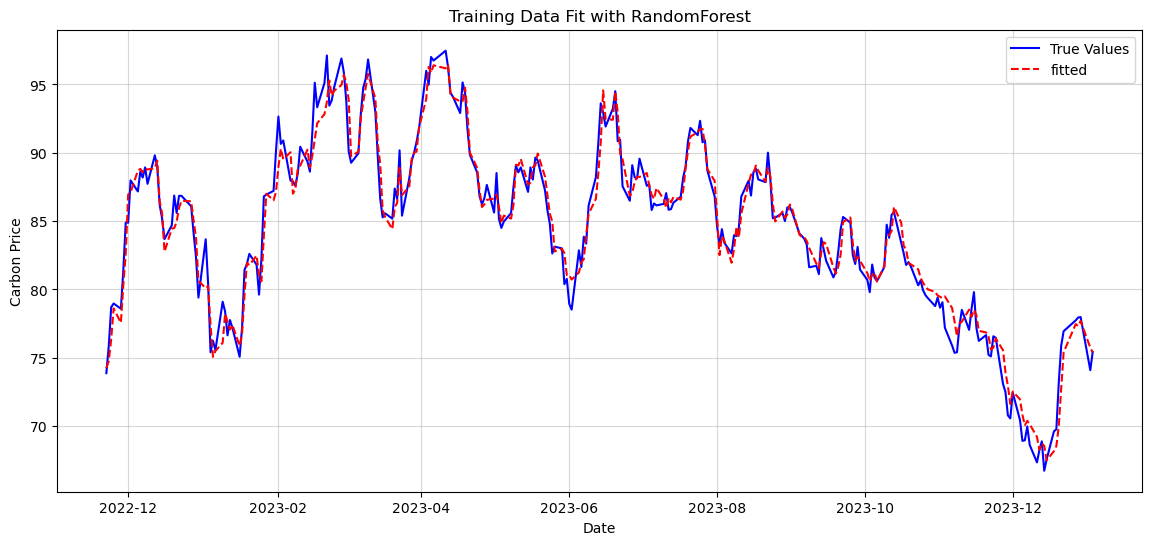

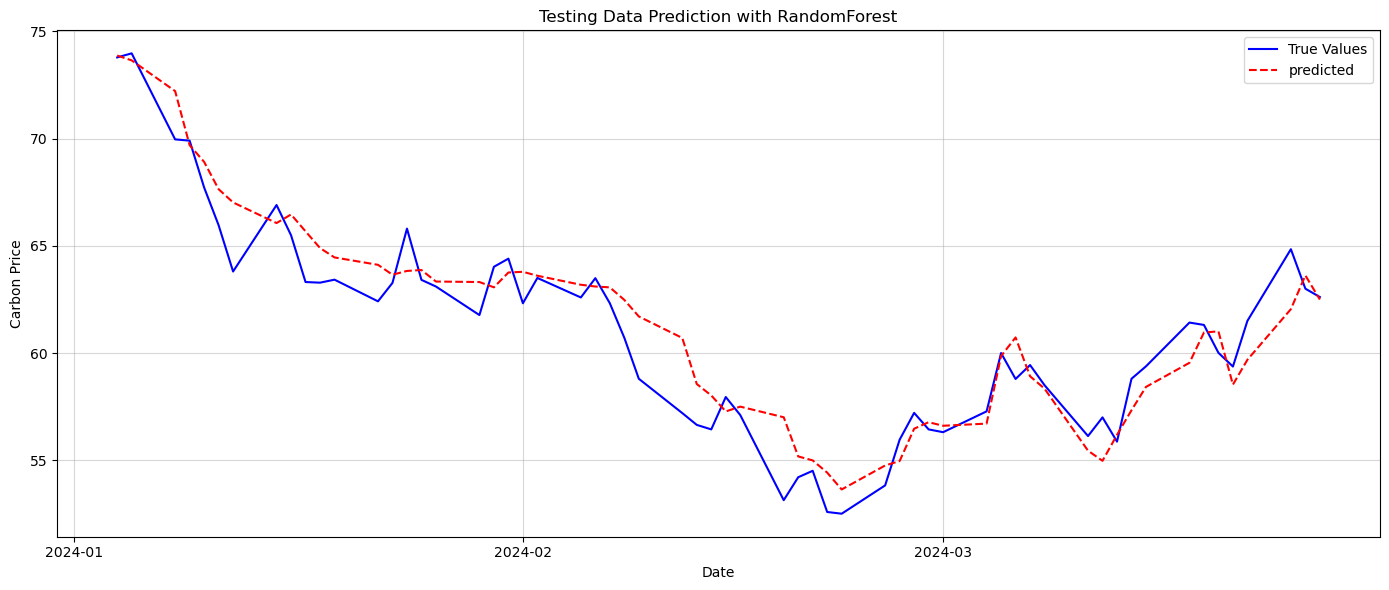

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from tqdm import tqdm
from collections import Counter

features = ['carbon.High', 'carbon.Low', 'carbon.Price_MA(1,12)', 'carbon.Open', 'carbon.Price_MOM(9)', 'carbon.Price_MOM(12)', 'zvj24.Price', 'clean', 'rvh24.Price', 'carbon.Price_MA(3,12)', 'ruh24.Price', 'carbon.Price_MA(2,12)', 'zuj24.Price']

X = df[features].values
y = df[target].values

# 參數設置
window_size = 90
test_size = 60
start_index = len(df) - test_size  # 測試集開始的位置
    
# 定義參數網格
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# 用於追蹤最佳參數
train_best_params = []
test_best_params = []

# Training
train_predictions = []
train_true_values = []
train_dates = []
for i in tqdm(range(window_size, start_index), desc='Training Progress'):
    X_train_window = X[i-window_size:i]
    y_train_window = y[i-window_size:i]
    X_test_window = X[i:i+1]

    # 初始化模型
    rf = RandomForestRegressor(random_state=42)
        
    # 使用 GridSearchCV 進行參數調優
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )
        
    # 訓練模型
    grid_search.fit(X_train_window, y_train_window)
    
    # 追蹤最佳參數
    train_best_params.append(grid_search.best_params_)
    
    # 使用最佳模型進行預測
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test_window)[0]
    
    # 預測
    train_predictions.append(y_pred)
    train_true_values.append(y[i])
    train_dates.append(df.index[i])

# Testing
test_predictions = []
test_true_values = []
test_dates = []

for i in tqdm(range(start_index, len(df)), desc='Testing Progress'):
    X_train_window = X[i-window_size:i]
    y_train_window = y[i-window_size:i]
    X_test_window = X[i:i+1]

    # 初始化模型
    rf = RandomForestRegressor(random_state=42)
        
    # 使用 GridSearchCV 進行參數調優
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )
    
    # 訓練模型
    grid_search.fit(X_train_window, y_train_window)

    # 追蹤最佳參數
    test_best_params.append(grid_search.best_params_)

    # 使用最佳參數建立模型
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test_window)[0]

    test_predictions.append(y_pred)
    test_true_values.append(y[i])
    test_dates.append(df.index[i])

# 訓練集評估
train_rmse = np.sqrt(mean_squared_error(train_true_values, train_predictions))
train_r2 = r2_score(train_true_values, train_predictions)

# 測試集評估
test_rmse = np.sqrt(mean_squared_error(test_true_values, test_predictions))
test_r2 = r2_score(test_true_values, test_predictions)

print(f"Train RMSE: {train_rmse:.2f}, Train R²: {train_r2:.2f}")
print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

# 分析最佳參數
def analyze_best_params(best_params_list):
    params_summary = {}
    for param_name in param_grid.keys():
        values = [params[param_name] for params in best_params_list]
        most_common = Counter(values).most_common(1)[0][0]
        params_summary[param_name] = {
            'most_frequent': most_common,
            'value_counts': dict(Counter(values))
        }
    return params_summary

print("\nTraining Best Parameters Summary:")
train_params_summary = analyze_best_params(train_best_params)
for param, summary in train_params_summary.items():
    print(f"{param}: {summary}")

print("\nTesting Best Parameters Summary:")
test_params_summary = analyze_best_params(test_best_params)
for param, summary in test_params_summary.items():
    print(f"{param}: {summary}")

# 圖表部分保持不變
plt.figure(figsize=(14, 6))
plt.plot(train_dates, train_true_values, label='True Values', color='blue')
plt.plot(train_dates, train_predictions, label='fitted', color='red', linestyle='--')
plt.title('Training Data Fit with RandomForest')
plt.xlabel('Date')
plt.ylabel('Carbon Price')
plt.legend()
plt.grid(alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.figure(figsize=(14, 6))
plt.plot(test_dates, test_true_values, label='True Values', color='blue')
plt.plot(test_dates, test_predictions, label='predicted', color='red', linestyle='--')
plt.title('Testing Data Prediction with RandomForest')
plt.xlabel('Date')
plt.ylabel('Carbon Price')
plt.legend()
plt.grid(alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.tight_layout()
plt.show()